In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

# 숫자형 데이터 지수표현법에서 float로 변경
pd.options.display.float_format = '{:.5f}'.format

### Purchase Log 파일 전처리

In [2]:
# 데이터 load 및 created_at, sign_up_date 날짜 형식으로 변환
chai = pd.read_csv('chai.csv', encoding = 'utf-8')
chai['created_at'] = pd.to_datetime(chai['created_at'])
chai['sign_up_date'] = pd.to_datetime(chai['sign_up_date'])

In [3]:
chai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5623810 entries, 0 to 5623809
Data columns (total 13 columns):
 #   Column           Dtype         
---  ------           -----         
 0   customer_id      int64         
 1   created_at       datetime64[ns]
 2   pre_discount     int64         
 3   post_discount    int64         
 4   cashback_amount  int64         
 5   discount_amount  int64         
 6   total_promotion  int64         
 7   push_permission  bool          
 8   gender           object        
 9   is_foreigner     bool          
 10  birthday         object        
 11  sign_up_date     datetime64[ns]
 12  merchant_id      int64         
dtypes: bool(2), datetime64[ns](2), int64(7), object(2)
memory usage: 482.7+ MB


In [4]:
## 신규 컬럼 추가

# 컬럼 추가: 캐시백 %, 할인 %
chai_dc = chai.iloc[chai[chai['discount_amount'] > 0].index]
chai_cb = chai.iloc[chai[chai['cashback_amount'] > 0].index]
chai['dc_pct'] = (chai_dc['discount_amount'] / chai_dc['pre_discount'])
chai['cb_pct'] = (chai_cb['cashback_amount'] / chai_cb['post_discount'])

# 컬럼 추가: 캐시백 적립 / 할인 / 할인 + 캐시백
chai['type'] = 1
chai.loc[chai[(chai['discount_amount'] != 0) & (chai['cashback_amount'] == 0)].index, 'type'] = 'dc'
chai.loc[chai[(chai['cashback_amount'] != 0) & (chai['discount_amount'] == 0)].index, 'type'] = 'cb'
chai.loc[chai[(chai['cashback_amount'] != 0) & (chai['discount_amount'] != 0)].index, 'type'] = 'dc + cb'
chai.loc[chai[(chai['cashback_amount'] == 0) & (chai['discount_amount'] == 0)].index, 'type'] = 'n.a'

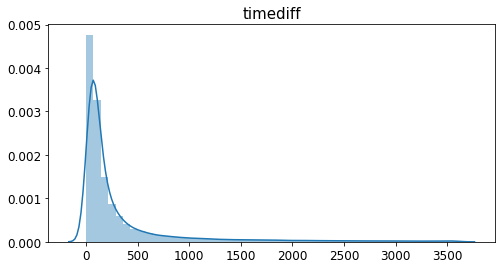

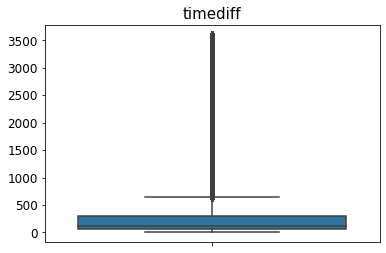

In [5]:
## 비정상 결제 / 취소 후 재결제 건 전처리

# customer_id, post_discount, total_promotion이 동일한 로그의 creeated at Lag 값 구하기 NaT면 첫 결제 건, 이전 결제에서 걸린 시간 컬럼 추가
chai['created_at_lag'] = chai.sort_values(['created_at'])\
                        .groupby(['customer_id', 'post_discount', 'total_promotion'])['created_at'].shift(1)
chai['created_at_diff'] = chai['created_at'] - chai['created_at_lag']
chai['created_at_diff'] = chai['created_at_diff'].dt.total_seconds()

# 동일 customerid, post discount, total promotion 가진 로그 중 lag 24시간 이내 시각화
dup = chai[chai.duplicated(['customer_id', 'post_discount', 'total_promotion'])]
dup.sort_values(['customer_id', 'post_discount', 'total_promotion', 'created_at'])

# histogram 시각화
f, ax = plt.subplots(1, figsize = (8, 4))
sns.distplot(x = dup[dup['created_at_diff'] < 3600]['created_at_diff'], ax = ax)
ax.set_title('timediff', size=15)
ax.set_ylabel('')
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params(axis = 'x', labelsize = 12)
# boxplot 시각화
f, ax = plt.subplots(1, figsize = (6, 4))
sns.boxplot(y = dup[dup['created_at_diff'] < 3600]['created_at_diff'], ax = ax)
ax.set_title('timediff', size=15)
ax.set_ylabel('')
ax.tick_params(axis = 'y', labelsize = 12)

# lag 24시간 이내 값 중 outlier를 제외한 값 전처리
q1 = dup[dup['created_at_diff'] < 3600]['created_at_diff'].quantile(0.25)
q3 = dup[dup['created_at_diff'] < 3600]['created_at_diff'].quantile(0.75)
iqr = q3 - q1
outlier = q3 + 1.5 * iqr
chai.drop(dup[dup['created_at_diff'] < outlier]['created_at_diff'].index, inplace = True)
chai.reset_index(drop = True, inplace = True)

# 컬럼 삭제
chai.drop(columns = ['created_at_diff', 'created_at_lag'], inplace = True)

In [7]:
# 캐시백 구매 건 구매일시 outlier 제거
chai.drop(index = chai[chai['type'] == 'dc + cb']['created_at'].sort_values()[:1].index, inplace = True)

In [8]:
chai.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5525903 entries, 0 to 5525903
Data columns (total 16 columns):
 #   Column           Dtype         
---  ------           -----         
 0   customer_id      int64         
 1   created_at       datetime64[ns]
 2   pre_discount     int64         
 3   post_discount    int64         
 4   cashback_amount  int64         
 5   discount_amount  int64         
 6   total_promotion  int64         
 7   push_permission  bool          
 8   gender           object        
 9   is_foreigner     bool          
 10  birthday         object        
 11  sign_up_date     datetime64[ns]
 12  merchant_id      int64         
 13  dc_pct           float64       
 14  cb_pct           float64       
 15  type             object        
dtypes: bool(2), datetime64[ns](2), float64(2), int64(7), object(3)
memory usage: 642.9+ MB


In [9]:
chai.to_csv('chai_processed.csv', encoding = 'utf-8', index = False)

### RFM 분석 컬럼 추가

• Recency : 얼마나 최근에 구매했는가 </br>
• Frequency : 얼마나 자주 구매했는가 </br>
• Monetary : 얼마나 많은 금액을 지출했는가

In [12]:
users = chai.groupby('customer_id').agg({'created_at' : ['max','nunique'], 'post_discount' : 'sum'}).reset_index()
users.columns  = users.columns.droplevel(1)
users.columns = ['customer_id', 'recency', 'frequency', 'monetary']
users['recency'] = users['recency'].dt.date
users['recency'] = (users['recency'].max() - users['recency']).dt.days

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544921 entries, 0 to 544920
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   customer_id  544921 non-null  int64
 1   recency      544921 non-null  int64
 2   frequency    544921 non-null  int64
 3   monetary     544921 non-null  int64
dtypes: int64(4)
memory usage: 16.6 MB


In [14]:
users.describe()

,customer_id,recency,frequency,monetary
count,544921.00000,544921.00000,544921.00000,544921.00000
mean,272461.00000,75.07346,10.14074,191158.69095
std,157305.28736,71.01839,20.12898,411243.04312
min,1.00000,0.00000,1.00000,0.00000
25%,136231.00000,18.00000,1.00000,19904.00000
50%,272461.00000,53.00000,3.00000,59900.00000
75%,408691.00000,114.00000,10.00000,189000.00000
max,544921.00000,243.00000,2327.00000,30967174.00000


Text(0, 0.5, '')

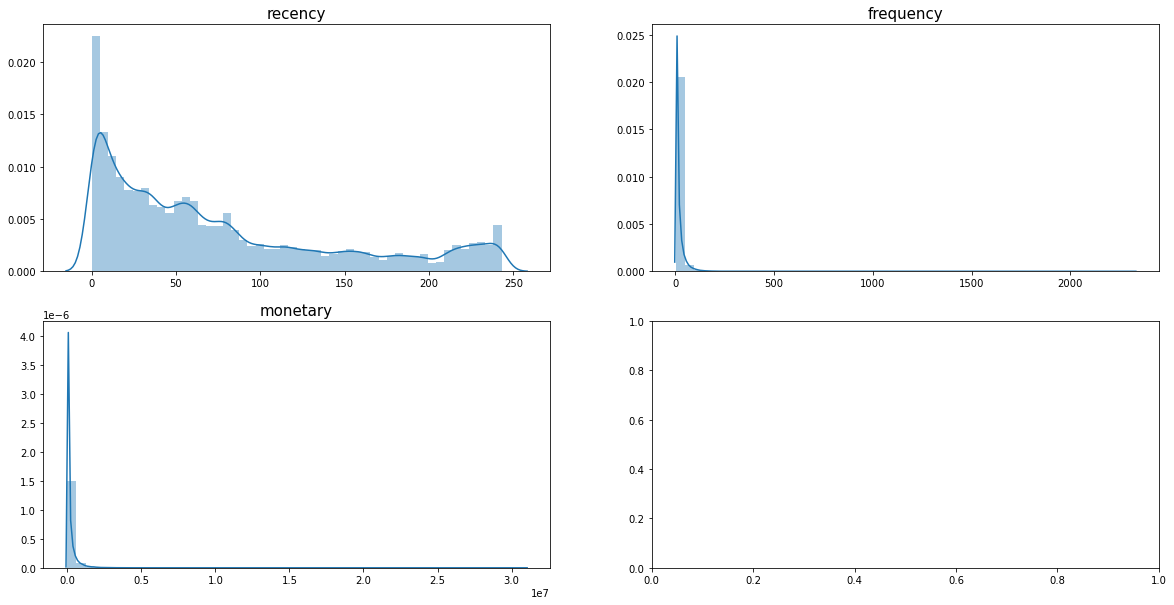

In [15]:
## RFM 시각화
f, ax = plt.subplots(2, 2, figsize = (20, 10))
sns.distplot(x = users['recency'], ax = ax[0,0])
ax[0,0].set_title('recency', size=15)
ax[0,0].set_ylabel('')
sns.distplot(x = users['frequency'], ax = ax[0,1])
ax[0,1].set_title('frequency', size=15)
ax[0,1].set_ylabel('')
sns.distplot(x = users['monetary'], ax = ax[1,0])
ax[1,0].set_title('monetary', size=15)
ax[1,0].set_ylabel('')

### RFM 스코어링

In [18]:
# R score
users['R_pct'] = users['recency'].rank(method = 'max') / len(users)
r1_min = min(users[users['R_pct'] > 0.8]['recency'])
r2_min = min(users[(users['R_pct'] <= 0.8) & (users['R_pct'] > 0.6)]['recency'])
r3_min = min(users[(users['R_pct'] <= 0.6) & (users['R_pct'] > 0.4)]['recency'])
r4_min = min(users[(users['R_pct'] <= 0.4) & (users['R_pct'] > 0.2)]['recency'])
print(f"R 1점: {r1_min}일 이상")
print(f"R 2점: {r2_min} ~ {r1_min - 1}일")
print(f"R 3점: {r3_min} ~ {r2_min - 1}일")
print(f"R 4점: {r4_min} ~ {r3_min - 1}일")
print(f"R 5점: {r4_min - 1}일 이하")

# scoring
users['R'] = 0
users.loc[users[users['recency'] >= r1_min].index, 'R'] = 1
users.loc[users[(users['recency'] < r1_min) & (users['recency'] >= r2_min)].index, 'R'] = 2
users.loc[users[(users['recency'] < r2_min) & (users['recency'] >= r3_min)].index, 'R'] = 3
users.loc[users[(users['recency'] < r3_min) & (users['recency'] >= r4_min)].index, 'R'] = 4
users.loc[users[(users['recency'] < r4_min)].index, 'R'] = 5
users.drop(columns = 'R_pct', inplace = True)

R 1점: 139일 이상
R 2점: 70 ~ 138일
R 3점: 36 ~ 69일
R 4점: 12 ~ 35일
R 5점: 11일 이하


In [19]:
# F score
f1_max = 1
print(f"F 1점: {f1_max}회 구매자")
f2_max = int(users[users['frequency'] > 1].median().frequency - 1)
print(f"F 2점: {f1_max+1} ~ {f2_max}회 구매자")
f3_max = int(users[users['frequency'] > f2_max+1].median().frequency - 1)
print(f"F 3점: {f2_max+1} ~ {f3_max}회 구매자")
f4_max = int(users[users['frequency'] > f3_max+1].median().frequency - 1)
print(f"F 4점: {f3_max+1} ~ {f4_max}회 구매자")
print(f"F 5점: {f4_max+1}회 이상 구매자")

# scoring
users['F'] = 0
users.loc[users[users['frequency'] == f1_max].index, 'F'] = 1
users.loc[users[(users['frequency'] <= f2_max) & (users['frequency'] > f1_max)].index, 'F'] = 2
users.loc[users[(users['frequency'] <= f3_max) & (users['frequency'] > f2_max)].index, 'F'] = 3
users.loc[users[(users['frequency'] <= f4_max) & (users['frequency'] > f3_max)].index, 'F'] = 4
users.loc[users[(users['frequency'] > f4_max)].index, 'F'] = 5

F 1점: 1회 구매자
F 2점: 2 ~ 5회 구매자
F 3점: 6 ~ 15회 구매자
F 4점: 16 ~ 30회 구매자
F 5점: 31회 이상 구매자


In [22]:
# M score
users['M_pct'] = users['monetary'].sort_values(ascending = False).cumsum() / max(users['monetary'].sort_values(ascending = False).cumsum())
# m1_min = min(users[(users['M_pct'] > 0.95)]['monetary'])
# m1_max = max(users[(users['M_pct'] > 0.95)]['monetary'])
# print(f"M 1점: 구매액 {m1_min} ~ {m1_max}원")
# m2_min = min(users[(users['M_pct'] > 0.9) & (users['M_pct'] <= 0.95)]['monetary'])
# m2_max = max(users[(users['M_pct'] > 0.9) & (users['M_pct'] <= 0.95)]['monetary'])
# print(f"M 2점: 구매액 {m2_min} ~ {m2_max}원")
# m3_min = min(users[(users['M_pct'] > 0.7) & (users['M_pct'] <= 0.9)]['monetary'])
# m3_max = max(users[(users['M_pct'] > 0.7) & (users['M_pct'] <= 0.9)]['monetary'])
# print(f"M 3점: 구매액 {m3_min} ~ {m3_max}원")
# m4_min = min(users[(users['M_pct'] > 0.4) & (users['M_pct'] <= 0.7)]['monetary'])
# m4_max = max(users[(users['M_pct'] > 0.4) & (users['M_pct'] <= 0.7)]['monetary'])
# print(f"M 4점: 구매액 {m4_min} ~ {m4_max}원")
# m5_min = min(users[(users['M_pct'] <= 0.4)]['monetary'])
# m5_max = max(users[(users['M_pct'] <= 0.4)]['monetary'])
# print(f"M 5점: 구매액 {m5_min} ~ {m5_max}원")
# print("\n")
# print('----------- 금액대 정립 -----------')
m1_max = 180000
m2_max = 420000
m3_max = 800000
m4_max = 1500000
print(f"M 1점: 구매액 {m1_max}원 미만")
print(f"M 2점: 구매액 {m1_max} ~ {m2_max}원 미만")
print(f"M 3점: 구매액 {m2_max} ~ {m3_max}원 미만")
print(f"M 4점: 구매액 {m3_max} ~ {m4_max}원 미만")
print(f"M 5점: {m4_max}원 이상")
print("------------추가 Description------------")
print("M 1점: 5% 매출을 내는 ",round(len(users[users['monetary'] < m1_max]) / len(users)*100,2), "% 고객")
print("M 2점: 5% 매출을 내는",round(len(users[(users['monetary'] < m2_max) & (users['monetary'] >= m1_max)])*100 / len(users),2), "% 고객")
print("M 3점: 20% 매출을 내는",round(len(users[(users['monetary'] < m3_max) & (users['monetary'] >= m2_max)])*100 / len(users),2), "% 고객")
print("M 4점: 30% 매출을 내는",round(len(users[(users['monetary'] < m4_max) & (users['monetary'] >= m3_max)])*100 / len(users),2), "% 고객")
print("M 5점: 40% 매출을 내는",round(len(users[(users['monetary'] >= m4_max)]) / len(users)*100,2), "% 고객")

# scoring
users['M'] = 0
users.loc[users[users['monetary'] < m1_max].index, 'M'] = 1
users.loc[users[(users['monetary'] < m2_max) & (users['monetary'] >= m1_max)].index, 'M'] = 2
users.loc[users[(users['monetary'] < m3_max) & (users['monetary'] >= m2_max)].index, 'M'] = 3
users.loc[users[(users['monetary'] < m4_max) & (users['monetary'] >= m3_max)].index, 'M'] = 4
users.loc[users[(users['monetary'] >= m4_max)].index, 'M'] = 5
users.drop(columns = 'M_pct', inplace = True)

M 1점: 구매액 180000원 미만
M 2점: 구매액 180000 ~ 420000원 미만
M 3점: 구매액 420000 ~ 800000원 미만
M 4점: 구매액 800000 ~ 1500000원 미만
M 5점: 1500000원 이상
------------추가 Description------------
M 1점: 5% 매출을 내는  74.04 % 고객
M 2점: 5% 매출을 내는 14.11 % 고객
M 3점: 20% 매출을 내는 6.7 % 고객
M 4점: 30% 매출을 내는 3.58 % 고객
M 5점: 40% 매출을 내는 1.57 % 고객


In [23]:
users.to_csv('users_RFM.csv', encoding = 'utf-8', index = False)